<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled258.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================
# BLOCK A — Install + Imports
# ==============================
!pip install -q gemmi pyscf

import os, json, numpy as np, gemmi
from pyscf import gto, dft
from pyscf.dft import numint
import matplotlib.pyplot as plt

project_root = "/content/gqr_fe4s4_ispG"
os.makedirs(project_root, exist_ok=True)
os.chdir(project_root)
print("Working directory:", os.getcwd())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 10.1 MB/s eta 0:00:00
Working directory: /content/gqr_fe4s4_ispG


In [ ]:
# ==============================
# BLOCK B — NPZ GENERATOR
# ==============================

L_EFF = 3.0   # Δr = L_eff / bins
BINS = list(range(40, 126))  # good curvature resolution region


# ---------- CIF → Fe & S ----------
def load_fes_from_cif(cif_path):
    doc = gemmi.cif.read_file(cif_path)
    block = doc.sole_block()
    st = gemmi.make_structure_from_block(block)
    model = st[0]

    xs, syms = [], []
    for chain in model:
        for res in chain:
            for atom in res:
                el = atom.element.name.upper()
                if el.startswith("FE") or el == "S":
                    syms.append("Fe" if el.startswith("FE") else "S")
                    xs.append([atom.pos.x, atom.pos.y, atom.pos.z])

    return np.array(xs), np.array(syms)


# ---------- connectivity clustering ----------
def cluster(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            if np.linalg.norm(coords[i] - coords[j]) < cutoff:
                adj[i].append(j)
                adj[j].append(i)

    seen = [False]*N
    comps = []
    for i in range(N):
        if not seen[i]:
            stack = [i]; seen[i] = True; comp=[]
            while stack:
                k = stack.pop(); comp.append(k)
                for nb in adj[k]:
                    if not seen[nb]:
                        seen[nb] = True
                        stack.append(nb)
            comps.append(comp)
    return comps


# ---------- find Fe4S4 ----------
def get_fe4s4(coords, syms):
    comps = cluster(coords, cutoff=3.0)
    for comp in comps:
        s = syms[comp]
        if np.sum(s=="Fe") == 4 and np.sum(s=="S") >= 4:
            return comp
    raise RuntimeError("No Fe4S4 found.")


# ---------- SCF + curvature ----------
def curvature(symbols, coords, box=3.5, ngrid=24):
    """Lightweight SCF + Laplacian curvature PDF."""
    atom_str = "\n".join(f"{s} {x} {y} {z}"
                         for s,(x,y,z) in zip(symbols, coords))

    mol = gto.M(atom=atom_str, basis="sto-3g", spin=0, charge=0)
    mf = dft.RKS(mol); mf.xc="PBE"; mf.max_cycle=80; mf.conv_tol=1e-5
    mf.kernel()

    xs = np.linspace(-box, box, ngrid)
    X,Y,Z = np.meshgrid(xs, xs, xs, indexing="ij")
    grid = np.stack([X.ravel(),Y.ravel(),Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid)
    rho = ni.eval_rho(mol, ao, mf.make_rdm1()).reshape((ngrid,ngrid,ngrid))

    dx = xs[1]-xs[0]
    lap = (np.gradient(np.gradient(rho,dx,axis=0),dx,axis=0) +
           np.gradient(np.gradient(rho,dx,axis=1),dx,axis=1) +
           np.gradient(np.gradient(rho,dx,axis=2),dx,axis=2))

    mask = rho > 1e-3
    kappa = np.abs(lap[mask].ravel())
    return np.clip(kappa, 0, np.percentile(kappa,99.5))


# ---------- Mode B asymmetric stretch ----------
def modeB(coords, symbols, amp=0.20):
    coords = coords.copy()
    Fe = [i for i,s in enumerate(symbols) if s=="Fe"]
    S  = [i for i,s in enumerate(symbols) if s=="S"]

    # nearest S to each Fe
    pairs=[]
    for fi in Fe:
        r = coords[fi]
        d = [np.linalg.norm(coords[si]-r) for si in S]
        si = S[int(np.argmin(d))]
        pairs.append((fi,si))

    # stretch 2 opposite Fe–S
    def st(C, i_fe, i_s, d):
        v = C[i_s]-C[i_fe]; L=np.linalg.norm(v)
        if L<1e-6: return C
        u=v/L
        C[i_fe]-=0.5*d*u; C[i_s]+=0.5*d*u
        return C

    if len(pairs)>=2:
        st(coords, pairs[0][0], pairs[0][1], +amp)
        st(coords, pairs[1][0], pairs[1][1], -amp)
    return coords


# ---------- Δteeth ----------
def delta_teeth(kappa_base, kappa_mode):
    rows=[]
    for b in BINS:
        cb,_ = np.histogram(kappa_base, b, density=True)
        cm,_ = np.histogram(kappa_mode, b, density=True)
        tb = np.sum(cb < 1e-9)
        tm = np.sum(cm < 1e-9)
        rows.append({
            "bins": b,
            "Delta_r_A": L_EFF/b,
            "Delta_teeth": int(tm-tb)
        })
    return rows


# ---------- full processing ----------
def process(tag, cif):
    print(f"\n=== {tag} ===")

    X, S = load_fes_from_cif(cif)
    comp = get_fe4s4(X, S)

    symbols = S[comp]
    coords0 = X[comp] - X[comp].mean(axis=0)

    # base
    kappa_base = curvature(symbols, coords0)

    # stretched
    coords1 = modeB(coords0, symbols, amp=0.20)
    kappa_mode = curvature(symbols, coords1)

    npz = f"{tag}_fe4s4_modeB.npz"
    np.savez(npz,
             symbols=symbols,
             coords_base=coords0,
             coords_mode=coords1,
             kappa_base=kappa_base,
             kappa_mode=kappa_mode,
             tag=tag)
    print("Saved NPZ:", npz)

    # Δteeth JSON
    rows = delta_teeth(kappa_base, kappa_mode)
    with open(f"{tag}_DeltaTeeth.json","w") as f:
        json.dump(rows, f, indent=2)
    print("Saved JSON.")

In [ ]:
# ==============================
# BLOCK C — RUN FOR ALL
# ==============================

targets = [
    ("4S38", "4S38.cif"),
    ("4S39", "4S39.cif"),
    ("4S3A", "4S3A.cif"),
    ("4S3B", "4S3B.cif"),
    ("4S3C", "4S3C.cif"),
    ("4S3D", "4S3D.cif"),
    ("4S3E", "4S3E.cif"),
    ("4S3F", "4S3F.cif"),
]

for tag, cif in targets:
    try:
        process(tag, cif)
    except Exception as e:
        print("ERROR:", tag, e)


=== 4S38 ===
SCF not converged.
SCF energy = -7705.91175272722
SCF not converged.
SCF energy = -7711.10200856788
Saved NPZ: 4S38_fe4s4_modeB.npz
Saved JSON.

=== 4S39 ===
SCF not converged.
SCF energy = -7704.11636832432
SCF not converged.
SCF energy = -7710.6480507684
Saved NPZ: 4S39_fe4s4_modeB.npz
Saved JSON.

=== 4S3A ===
SCF not converged.
SCF energy = -7706.75349191148
SCF not converged.
SCF energy = -7705.7440006193
Saved NPZ: 4S3A_fe4s4_modeB.npz
Saved JSON.

=== 4S3B ===
SCF not converged.
SCF energy = -7708.28704399027
SCF not converged.
SCF energy = -7706.75216873016
Saved NPZ: 4S3B_fe4s4_modeB.npz
Saved JSON.

=== 4S3C ===
SCF not converged.
SCF energy = -7705.00061601894
SCF not converged.
SCF energy = -7706.44729295402
Saved NPZ: 4S3C_fe4s4_modeB.npz
Saved JSON.

=== 4S3D ===
ERROR: 4S3D No Fe4S4 found.

=== 4S3E ===
SCF not converged.
SCF energy = -7710.42771949612
SCF not converged.
SCF energy = -7708.60267368642
Saved NPZ: 4S3E_fe4s4_modeB.npz
Saved JSON.

=== 4S3F ==

In [ ]:
# ============================
# BLOCK P1 — HOMO PLOTTER FROM NPZ
# ============================

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

project_root = "/content/gqr_fe4s4_gqr"  # <-- change if needed
os.chdir(project_root)
print("Working in:", os.getcwd())


def load_homo_npz(npz_path):
    """
    Load HOMO clouds from an npz file in a tolerant way.
    Supports both:
      - older: coords_base / psi_base / coords_mode / psi_mode
      - newer: coords_cloud_base / psi_cloud_base / coords_cloud_st / psi_st
      - optional: symbols / coords_centered
    """
    data = np.load(npz_path)

    keys = set(data.files)

    # Figure out base coords
    if "coords_cloud_base" in keys:
        coords_base = data["coords_cloud_base"]
    elif "coords_base" in keys:
        coords_base = data["coords_base"]
    else:
        raise KeyError(f"No base coordinates found in {npz_path}")

    # Base psi
    if "psi_base" in keys:
        psi_base = data["psi_base"]
    elif "psi_cloud_base" in keys:
        psi_base = data["psi_cloud_base"]
    else:
        raise KeyError(f"No base psi array found in {npz_path}")

    # Mode/stretched coords
    if "coords_cloud_st" in keys:
        coords_mode = data["coords_cloud_st"]
    elif "coords_mode" in keys:
        coords_mode = data["coords_mode"]
    else:
        raise KeyError(f"No mode/stretched coordinates found in {npz_path}")

    # Mode psi
    if "psi_mode" in keys:
        psi_mode = data["psi_mode"]
    elif "psi_st" in keys:
        psi_mode = data["psi_st"]
    else:
        raise KeyError(f"No stretched psi array found in {npz_path}")

    # Optional atomic positions
    atoms_coords = None
    if "coords_centered" in keys:
        atoms_coords = data["coords_centered"]
    elif "coords_atoms" in keys:
        atoms_coords = data["coords_atoms"]
    # Optional symbols
    symbols = data["elems"] if "elems" in keys else None
    if "symbols" in keys:
        symbols = data["symbols"]

    return coords_base, psi_base, coords_mode, psi_mode, atoms_coords, symbols


def plot_homo_pair_from_npz(npz_path):
    """
    Plot base vs stretched HOMO clouds from a HOMO npz file.
    """
    tag = os.path.basename(npz_path).replace(".npz", "")

    coords_b, psi_b, coords_m, psi_m, atoms, symbols = load_homo_npz(npz_path)

    fig = plt.figure(figsize=(10, 4))

    # Atom colour map if available
    atom_colors = {"Fe": "red", "S": "yellow"}

    # Panel A: base
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    colors_b = np.where(psi_b >= 0, "blue", "red")
    ax1.scatter(coords_b[:,0], coords_b[:,1], coords_b[:,2],
                s=4, c=colors_b, alpha=0.5)
    if atoms is not None and symbols is not None:
        for (x, y, z), s in zip(atoms, symbols):
            ax1.scatter(x, y, z, s=60,
                        c=atom_colors.get(str(s), "grey"),
                        edgecolors="k")
    ax1.set_title(f"{tag} — HOMO base")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    # Panel B: stretched
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors_m = np.where(psi_m >= 0, "cyan", "magenta")
    ax2.scatter(coords_m[:,0], coords_m[:,1], coords_m[:,2],
                s=4, c=colors_m, alpha=0.5)
    if atoms is not None and symbols is not None:
        for (x, y, z), s in zip(atoms, symbols):
            ax2.scatter(x, y, z, s=60,
                        c=atom_colors.get(str(s), "grey"),
                        edgecolors="k")
    ax2.set_title(f"{tag} — HOMO stretched")
    ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])

    # Common bounding box so they line up visually
    all_x = np.concatenate([coords_b[:,0], coords_m[:,0]])
    all_y = np.concatenate([coords_b[:,1], coords_m[:,1]])
    all_z = np.concatenate([coords_b[:,2], coords_m[:,2]])
    pad = 0.5
    for ax in (ax1, ax2):
        ax.set_xlim(all_x.min()-pad, all_x.max()+pad)
        ax.set_ylim(all_y.min()-pad, all_y.max()+pad)
        ax.set_zlim(all_z.min()-pad, all_z.max()+pad)

    plt.tight_layout()
    out_png = f"{tag}_HOMO_pair.png"
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gqr_fe4s4_gqr'

In [ ]:
mv /content/*.cif /content/gqr_fe4s4_ispG/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import shutil
import glob

# --- CONFIGURATION ------NB these codes now developed with gemini on this date entriely i think....quite confusing day...

folder_name = "teethnpz"
base_dir = "/content"
target_dir = os.path.join(base_dir, folder_name)

# 1. Create the folder
# exist_ok=True means it won't crash if you run this cell twice
os.makedirs(target_dir, exist_ok=True)
print(f"✅ Target directory ready: {target_dir}")

# 2. Find .npz files in the main /content directory
# This looks for any .npz file directly inside /content
files_to_move = glob.glob(os.path.join(base_dir, "*.npz"))

if not files_to_move:
    print("ℹ️  No .npz files found in /content. (Did you upload them yet?)")
else:
    print(f"Found {len(files_to_move)} .npz files. Moving them now...")

# 3. Move the files
count = 0
for file_path in files_to_move:
    filename = os.path.basename(file_path)
    new_path = os.path.join(target_dir, filename)

    try:
        shutil.move(file_path, new_path)
        print(f"  -> Moved: {filename}")
        count += 1
    except Exception as e:
        print(f"  ❌ Error moving {filename}: {e}")

print(f"\n🎉 Done! {count} files are now in {target_dir}")
print(f"You can now change directory with: os.chdir('{target_dir}')")


✅ Target directory ready: /content/teethnpz
Found 4 .npz files. Moving them now...
  -> Moved: inhib_base.npz
  -> Moved: inhib_dist.npz
  -> Moved: active_base.npz
  -> Moved: active_dist.npz

🎉 Done! 4 files are now in /content/teethnpz
You can now change directory with: os.chdir('/content/teethnpz')


<>:92: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
<>:92: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-552038809.py:92: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta r$ (Resolution in $\AA$)", fontsize=12)
/tmp/ipython-input-552038809.py:93: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$teeth (Stretched - Base)", fontsize=12)


Found 0 files to analyze.


/tmp/ipython-input-552038809.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


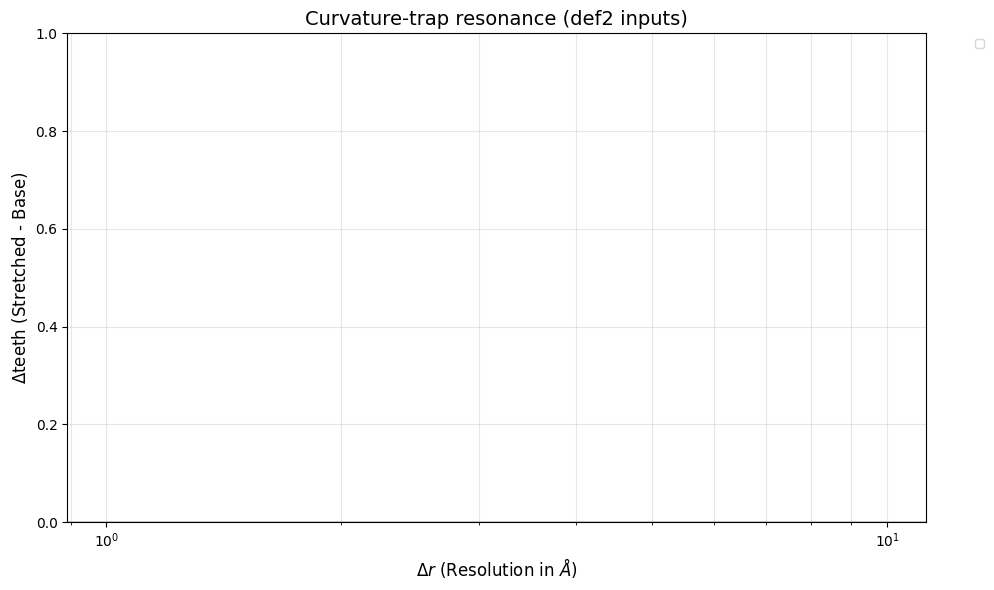

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. SETUP: Point to your folder
# Make sure your def2 .npz files are in this folder
# os.chdir("/content/teethnpz")

# 2. FILTER: Only grab the def2 files
# Assuming files are named like "4S38...def2...npz"
# If they aren't labeled 'def2' in the filename, just point to their specific folder.
npz_files = sorted([f for f in glob.glob("*def2*.npz")])

if not npz_files:
    print("WARNING: No 'def2' files found. plotting all npz files instead.")
    npz_files = sorted([f for f in glob.glob("*.npz")])

print(f"Found {len(npz_files)} files to analyze.")

# ---- Trap Counter ----
def count_traps(pdf, threshold=1e-9):
    low = pdf < threshold
    traps = 0
    i = 0
    n = len(low)
    while i < n:
        if low[i]:
            traps += 1
            while i < n and low[i]:
                i += 1
        else:
            i += 1
    return traps

# ---- The Calculator ----
def compute_teeth(npz_file, bins_list=[40,60,80,100,120,150,200], L_eff=3.0):
    d = np.load(npz_file)
    # Ensure we are using the right keys. Sometimes keys differ in npz files.
    # If 'kappa_base' fails, check if it's named 'k_base' etc.
    try:
        k_base = d["kappa_base"]
        k_mode = d["kappa_mode"]
    except KeyError:
        print(f"Skipping {npz_file}: Keys not found.")
        return []

    rows = []
    for b in bins_list:
        # Create the histogram (The "Ruler")
        edges = np.linspace(min(k_base.min(), k_mode.min()),
                            max(k_base.max(), k_mode.max()), b+1)

        hist_b, _ = np.histogram(k_base, bins=edges, density=True)
        hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

        # Count the features (The "Teeth")
        n_b = count_traps(hist_b)
        n_m = count_traps(hist_m)

        Δ = n_m - n_b

        # --- THE KEY CONVERSION ---
        # Convert "Bin Count" (b) to "Resolution" (Δr)
        Δr = L_eff / b

        rows.append([npz_file, b, Δr, Δ])

    return rows

# 3. EXECUTE: Run the loops
all_rows = []
for f in npz_files:
    all_rows += compute_teeth(f)

df = pd.DataFrame(all_rows, columns=["file", "bins", "Δr", "Δteeth"])

# 4. PLOT: Recreate the Manuscript Figure
plt.figure(figsize=(10, 6))

# Get unique files to plot separate lines
unique_files = df["file"].unique()

for f in unique_files:
    subset = df[df["file"] == f].sort_values(by="Δr")

    # Plot Δr on X (log scale) and Δteeth on Y
    plt.plot(subset["Δr"], subset["Δteeth"], marker='o', markersize=4, label=f)

plt.xscale("log") # Critical for the "manuscript look"
plt.axhline(0, color='black', linewidth=1) # The zero baseline
plt.xlabel("$\Delta r$ (Resolution in $\AA$)", fontsize=12)
plt.ylabel("$\Delta$teeth (Stretched - Base)", fontsize=12)
plt.title(f"Curvature-trap resonance (def2 inputs)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


Found 4 files to analyze in /content/teethnpz. Generating 24 points per file.
Skipping /content/teethnpz/active_base.npz: Keys 'kappa_base' or 'kappa_mode' not found.
Skipping /content/teethnpz/active_dist.npz: Keys 'kappa_base' or 'kappa_mode' not found.
Skipping /content/teethnpz/inhib_base.npz: Keys 'kappa_base' or 'kappa_mode' not found.
Skipping /content/teethnpz/inhib_dist.npz: Keys 'kappa_base' or 'kappa_mode' not found.
❌ No data rows generated. Check your input files and keys.


/tmp/ipython-input-1319105513.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


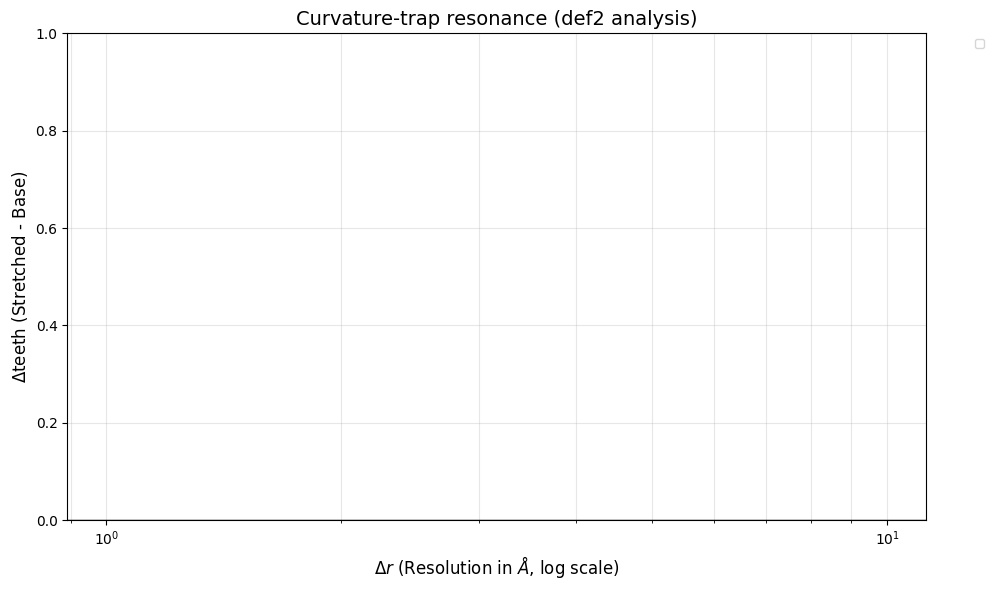

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION (Includes all your preferences) ---
TARGET_DIR = "/content/teethnpz"
L_EFF = 3.0 # Effective Length constant (Å)
# Thinned list: N=1 to N=120, using a step of 5 (24 points total per line)
BIN_LIST = np.arange(1, 121, 5)

# 1. FILE FINDING: Look inside the created folder
# Try finding only 'def2' files first, otherwise plot all.
npz_files = sorted(glob.glob(os.path.join(TARGET_DIR, "*def2*.npz")))

if not npz_files:
    print("WARNING: No 'def2' files found. Plotting ALL npz files instead.")
    npz_files = sorted(glob.glob(os.path.join(TARGET_DIR, "*.npz")))

print(f"Found {len(npz_files)} files to analyze in {TARGET_DIR}. Generating {len(BIN_LIST)} points per file.")

# --- Trap Counter Function ---
def count_traps(pdf, threshold=1e-9):
    low = pdf < threshold
    traps = 0
    i = 0
    n = len(low)
    while i < n:
        if low[i]:
            traps += 1
            while i < n and low[i]:
                i += 1
        else:
            i += 1
    return traps

# --- Δteeth Computation Function ---
def compute_teeth(npz_file, bins_list=BIN_LIST, L_eff=L_EFF):
    d = np.load(npz_file)
    try:
        k_base = d["kappa_base"]
        k_mode = d["kappa_mode"]
    except KeyError:
        print(f"Skipping {npz_file}: Keys 'kappa_base' or 'kappa_mode' not found.")
        return []

    rows = []
    for b in bins_list:
        # 1. Calculate the resolution edges
        edges = np.linspace(min(k_base.min(), k_mode.min()),
                            max(k_base.max(), k_mode.max()), b+1)

        # 2. Compute Histograms and Counts
        hist_b, _ = np.histogram(k_base, bins=edges, density=True)
        hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

        n_b = count_traps(hist_b)
        n_m = count_traps(hist_m)

        # 3. Calculate Results (Delta teeth and Delta r)
        Δ = n_m - n_b
        Δr = L_eff / b

        rows.append([os.path.basename(npz_file), b, Δr, Δ])
    return rows

# 2. EXECUTE: Run the analysis
all_rows = []
for f in npz_files:
    all_rows += compute_teeth(f)

if not all_rows:
    print("❌ No data rows generated. Check your input files and keys.")
    exit()

df = pd.DataFrame(all_rows, columns=["file", "bins", "Δr", "Δteeth"])

# 3. PLOT: Recreate the Manuscript Figure
plt.figure(figsize=(10, 6))
unique_files = df["file"].unique()

for f in unique_files:
    subset = df[df["file"] == f].sort_values(by="Δr")
    # Use a line plot with markers for the curvature-trap style
    plt.plot(subset["Δr"], subset["Δteeth"], marker='o', markersize=4, label=f)

plt.xscale("log")
plt.axhline(0, color='black', linewidth=1)

# Use raw strings (r"...") to correctly display LaTeX labels
plt.xlabel(r"$\Delta r$ (Resolution in $\AA$, log scale)", fontsize=12)
plt.ylabel(r"$\Delta$teeth (Stretched - Base)", fontsize=12)

plt.title(f"Curvature-trap resonance (def2 analysis)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import os
import glob

# Configuration matching your previous run
TARGET_DIR = "/content/teethnpz"

# Find a sample file to check (using the first file found)
npz_files = glob.glob(os.path.join(TARGET_DIR, "*.npz"))

if npz_files:
    test_file_path = npz_files[0]
    filename = os.path.basename(test_file_path)
    print(f"Inspecting file: {filename}")

    try:
        data = np.load(test_file_path)
        # This line lists all the variable names (keys) inside the file
        print(f"Actual Keys found in {filename}:")
        print(list(data.keys()))

    except Exception as e:
        print(f"Error loading {filename}: {e}")
else:
    print("No .npz files found in /content/teethnpz.")


Inspecting file: inhib_base.npz
Actual Keys found in inhib_base.npz:
['laplacian', 'hist_density', 'hist_bins', 'trap_count']
